In [1]:
import os
import pandas as pd
import numpy as np
import math
import warnings
import matplotlib as mpl
import matplotlib.pyplot as plt
from pylab import rcParams
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
%matplotlib inline
warnings.filterwarnings('ignore')
from IPython.display import FileLink

In [2]:
# Reading datasets
train= pd.read_csv('criminal_train.csv')
test= pd.read_csv('criminal_test.csv')

In [3]:
train['Criminal'].value_counts()

0    42543
1     3175
Name: Criminal, dtype: int64

In [4]:
train_id=train['PERID']
target=train['Criminal']
target_set=pd.DataFrame(train_id).join(pd.DataFrame(target))
train= train.drop(['PERID', 'Criminal'], axis=1)
features=train.columns
test_id=test['PERID']
test= test.drop(['PERID'], axis=1)

In [5]:
weight = float(np.sum(target == 0)) / float(np.sum(target == 1))

In [6]:
# Concating train and test into one
data = pd.concat([train, test], ignore_index=True)

In [7]:
data= data.drop(['IIMEDICR', 'IIMCDCHP', 'IICHMPUS', 'IIPRVHLT', 'HLNVNEED', 'HLNVSOR', 'IROTHHLT','IIOTHHLT', 'IRINSUR4', 'IIINSUR4', 'TROUBUND', 'AIIND102', 'HLCLAST'], axis=1)

In [8]:
#Log Transform
for i in data.columns: 
    data[i] = np.log(1.5+data[i])

In [9]:
# Scaling linear variables
from sklearn.preprocessing import StandardScaler

cols_to_scale= data.columns
scaler = StandardScaler().fit(data[cols_to_scale])

data[cols_to_scale] = scaler.transform(data[cols_to_scale])

In [10]:
# Splitting back into train and test
train = data[:len(train)]
test  = data[len(train):]
test = test.reset_index(drop=True)

train = train.values
test  = test.values
target= target.values

In [11]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

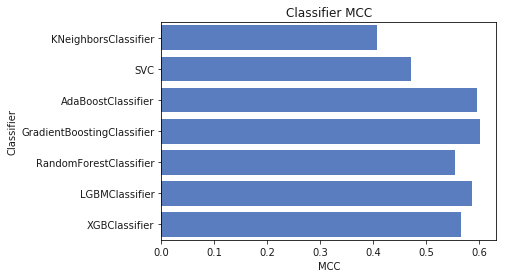

In [12]:
classifiers = [
    KNeighborsClassifier(3),
    SVC(probability=True),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),  
    RandomForestClassifier(class_weight={0:weight, 1:1}),
    lgb.LGBMClassifier(scale_pos_weight=weight),
    XGBClassifier(scale_pos_weight=weight)
]

log_cols = ["Classifier", "MCC"]
log  = pd.DataFrame(columns=log_cols)


X = train
y = target

mcc_dict = {}
preds_tr= {}

from sklearn import cross_validation
from sklearn.metrics import matthews_corrcoef
cv = cross_validation.KFold(len(train), n_folds=10)

for clf in classifiers:
    
    for traincv, testcv in cv:
        name = clf.__class__.__name__
        clf.fit(train[traincv], target[traincv])
        train_predictions = clf.predict(train[testcv])
        mcc = matthews_corrcoef(target[testcv], train_predictions)
        
        if name in mcc_dict:   # Train accuracies
            mcc_dict[name] += mcc
        else:
            mcc_dict[name] = mcc
            
        if name in preds_tr:   # Train predictions
            preds_tr[name]= np.concatenate((preds_tr[name], train_predictions), axis=0)
        else:
            preds_tr[name]= train_predictions

for clf in mcc_dict:
    mcc_dict[clf] = mcc_dict[clf] / 10.0
    log_entry = pd.DataFrame([[clf, mcc_dict[clf]]], columns=log_cols)
    log = log.append(log_entry)

plt.xlabel('MCC')
plt.title('Classifier MCC')

sns.set_color_codes("muted")
sns.barplot(x='MCC', y='Classifier', data=log, color="b")

In [13]:
# Test predictions for layer 1
X = train
y = target
preds_te= {}

for clf in classifiers:
        name = clf.__class__.__name__
        clf.fit(X, y)
        test_predictions= clf.predict(test)
        preds_te[name] = test_predictions

predictions_te1 = pd.DataFrame(preds_te)  # test predictions
predictions_tr1 = pd.DataFrame(preds_tr)  # train predictions

## Second layer models

In [14]:
train2 = data[:len(train)]
test2  = data[len(train):]
test2 = test2.reset_index(drop=True)

train2= train2.join(predictions_tr1)
test2= test2.join(predictions_te1)

train2 = train2.reset_index(drop=True)
test2 = test2.reset_index(drop=True)

In [15]:
# Ensembling & Stacking models

from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

In [16]:
train=train2
test=test2

In [17]:
rf=RandomForestClassifier(class_weight={0:weight, 1:1})
ad=AdaBoostClassifier()
gb=GradientBoostingClassifier()
lgb=lgb.LGBMClassifier(scale_pos_weight=weight)
xgb=XGBClassifier(scale_pos_weight=weight)
knn=KNeighborsClassifier(3)
svc=SVC(probability=True)

In [18]:
estimators=[('rf', rf), ('ad', ad), ('gb', gb), ('lgb', lgb), ('xgb', xgb), ('knn', knn), ('svc', svc)]

In [19]:
ensemble = VotingClassifier(estimators=estimators, voting='soft')

In [20]:
ensemble = ensemble.fit(train, target)

In [21]:
output= ensemble.predict(test)

In [22]:
sub = pd.DataFrame({'PERID': test_id, 'Criminal': output})
sub = sub[['PERID', 'Criminal']]
filename = 'prediction.csv'
sub.to_csv(filename, index=False)
FileLink(filename)

/media/nikhil/Beta/Workspace/Data/Competitions/Predict the Criminal/best/criminal/prediction.csv